<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib.lines import Line2D
import qgrid
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import os
import re
import itertools as itr
from src.visualize.visualize import plot_correlation_density, plot_vector, plot_lambda_collectivity
from src.enm import Enm
from src.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%load_ext rpy2.ipython


/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [3]:
os.chdir('../')

In [4]:
with open(f'data/interim/pcc_0909/pcc.pickle','rb') as f:
    e_pcc = pickle.load(f)

In [5]:
sensors_pcc = e_pcc.df.loc[e_pcc.df.sens>np.quantile(e_pcc.df.sens,0.99)]
sensor_sub_pcc = get_subnetwork(e_pcc.graph_gc, sensors_pcc.orf_name.values)
is_sensor = dict(zip(sensor_sub_pcc.nodes, [True if i in sensors_pcc.orf_name.values else False  for i in sensor_sub_pcc.nodes]))
nx.set_node_attributes(sensor_sub_pcc, is_sensor, 'is_sensor')
sensor_go_terms_separate = [
    'iron ion\ntransport',
    'phenylalanine\ntransport',
    None, 
    None,
    None,
    None,
    'tricarboxylic\nacid cycle', 
    'hexose metabolic\nprocess',
    'protein folding',
    'mitochondria-nucleus\nsignaling pathway/TCA',
    None,
    None,
    None,
    None,
    None,
    None,
    None,
]
sensor_connected_components = sorted([sorted(list(i)) for i in nx.connected_components(nx.induced_subgraph(e_pcc.graph_gc, sensors_pcc.orf_name))], key=lambda x: x[0])
sensor_go_terms= {}
for i in range(len(sensor_go_terms_separate)):
    for j in sensor_connected_components[i]:
        sensor_go_terms[j] = sensor_go_terms_separate[i]

In [6]:
sensors_pcc = sensors_pcc.merge(pd.DataFrame.from_dict(sensor_go_terms,orient='index',columns=['go_group']),right_index=True,left_on='orf_name')

In [7]:
effector_pcc = e_pcc.df.loc[e_pcc.df.eff>np.quantile(e_pcc.df.eff,0.99)]
effector_sub_pcc = get_subnetwork(e_pcc.graph_gc, effector_pcc.orf_name.values)
is_effector = dict(zip(effector_sub_pcc.nodes, [True if i in effector_pcc.orf_name.values else False  for i in effector_sub_pcc.nodes]))
nx.set_node_attributes(effector_sub_pcc, is_effector, 'is_effector')
effectors_connected_comp = sorted([sorted(list(i)) for i in nx.connected_components(nx.induced_subgraph(e_pcc.graph_gc, effector_pcc.orf_name.tolist()))], key=lambda x:x[0])
effector_pcc.loc[:, 'go_group'] = ['mito' if i in effectors_connected_comp[0] else 'golgi' if i in effectors_connected_comp[1] else 'chromatin' for i in effector_pcc.orf_name]

/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [8]:
%%R -o sensor_colors -o effector_colors
library(RColorBrewer)
col = brewer.pal(n=9,name='Set1')
sensor_colors = col[1:6]
effector_colors = col[7:9]


In [9]:
effector_order = effector_pcc.groupby('go_group').eff.median().sort_values().index.tolist()
sensor_order = sensors_pcc.groupby('go_group').sens.median().sort_values().index.tolist()

In [11]:
import random
random.seed(2)
e_pcc.prs_mat_df=pd.DataFrame(e_pcc.prs_mat,columns=e_pcc.nodes, index=e_pcc.nodes)


In [12]:
folder = 'reports/figures/eff_sens_path_plots/'

In [13]:
index = pd.MultiIndex.from_product([effector_order,sensor_order], names=["effector", "sensor"])
eff_sens_df = pd.DataFrame([],index=index,columns=['orfs'])

['csm3', 'cdc45-27', 'ybr277c', 'ycr061w', 'ybr096w', 'yil175w', 'rpl42b', 'sse1', 'hsf1-848', 'sti1']
['csm3', 'pds1-128', 'shp1', 'abf1-102-supp1', 'oar1', 'lpd1-supp1', 'kgd2', 'hap2', 'sdh4', 'sdh2', 'fum1']
['csm3', 'ctf4', 'ctf19', 'spc25-1', 'nif3', 'don1', 'ycr102w-a', 'cst26', 'hpf1', 'ycr062w']
['csm3', 'hrp1-4', 'rsc8-ts16', 'eaf3', 'ygr125w', 'enb1', 'sit1', 'ftr1', 'fet3', 'ymr057c']
['csm3', 'cdc45-27', 'dpb3', 'ycr087w', 'dug2', 'ydl159w-a', 'rtg1', 'rtg2']
['csm3', 'pds1-128', 'shp1', 'abf1-102-supp1', 'oar1', 'lpd1-supp1', 'hom3', 'ydr157w', 'bap2', 'stp1', 'stp2', 'rma1']
['gpi17-5001', 'ecm33', 'com2', 'hap2', 'emi1', 'ups1', 'sse1', 'hsf1-848', 'sti1']
['gpi17-5001', 'ecm33', 'com2', 'hap2', 'sdh4', 'sdh2', 'fum1']
['gpi17-5001', 'api2', 'yir042c', 'ena5', 'frt2', 'ycr102w-a', 'cst26', 'hpf1', 'ycr062w']
['gpi17-5001', 'ecm33', 'com2', 'ylr154w-a', 'pan5', 'ynl277w-a', 'sit1', 'ftr1', 'fet3', 'ymr057c']
['gpi17-5001', 'mnn2', 'cct8-5001', 'cct7-5001', 'ydl159w-a', '

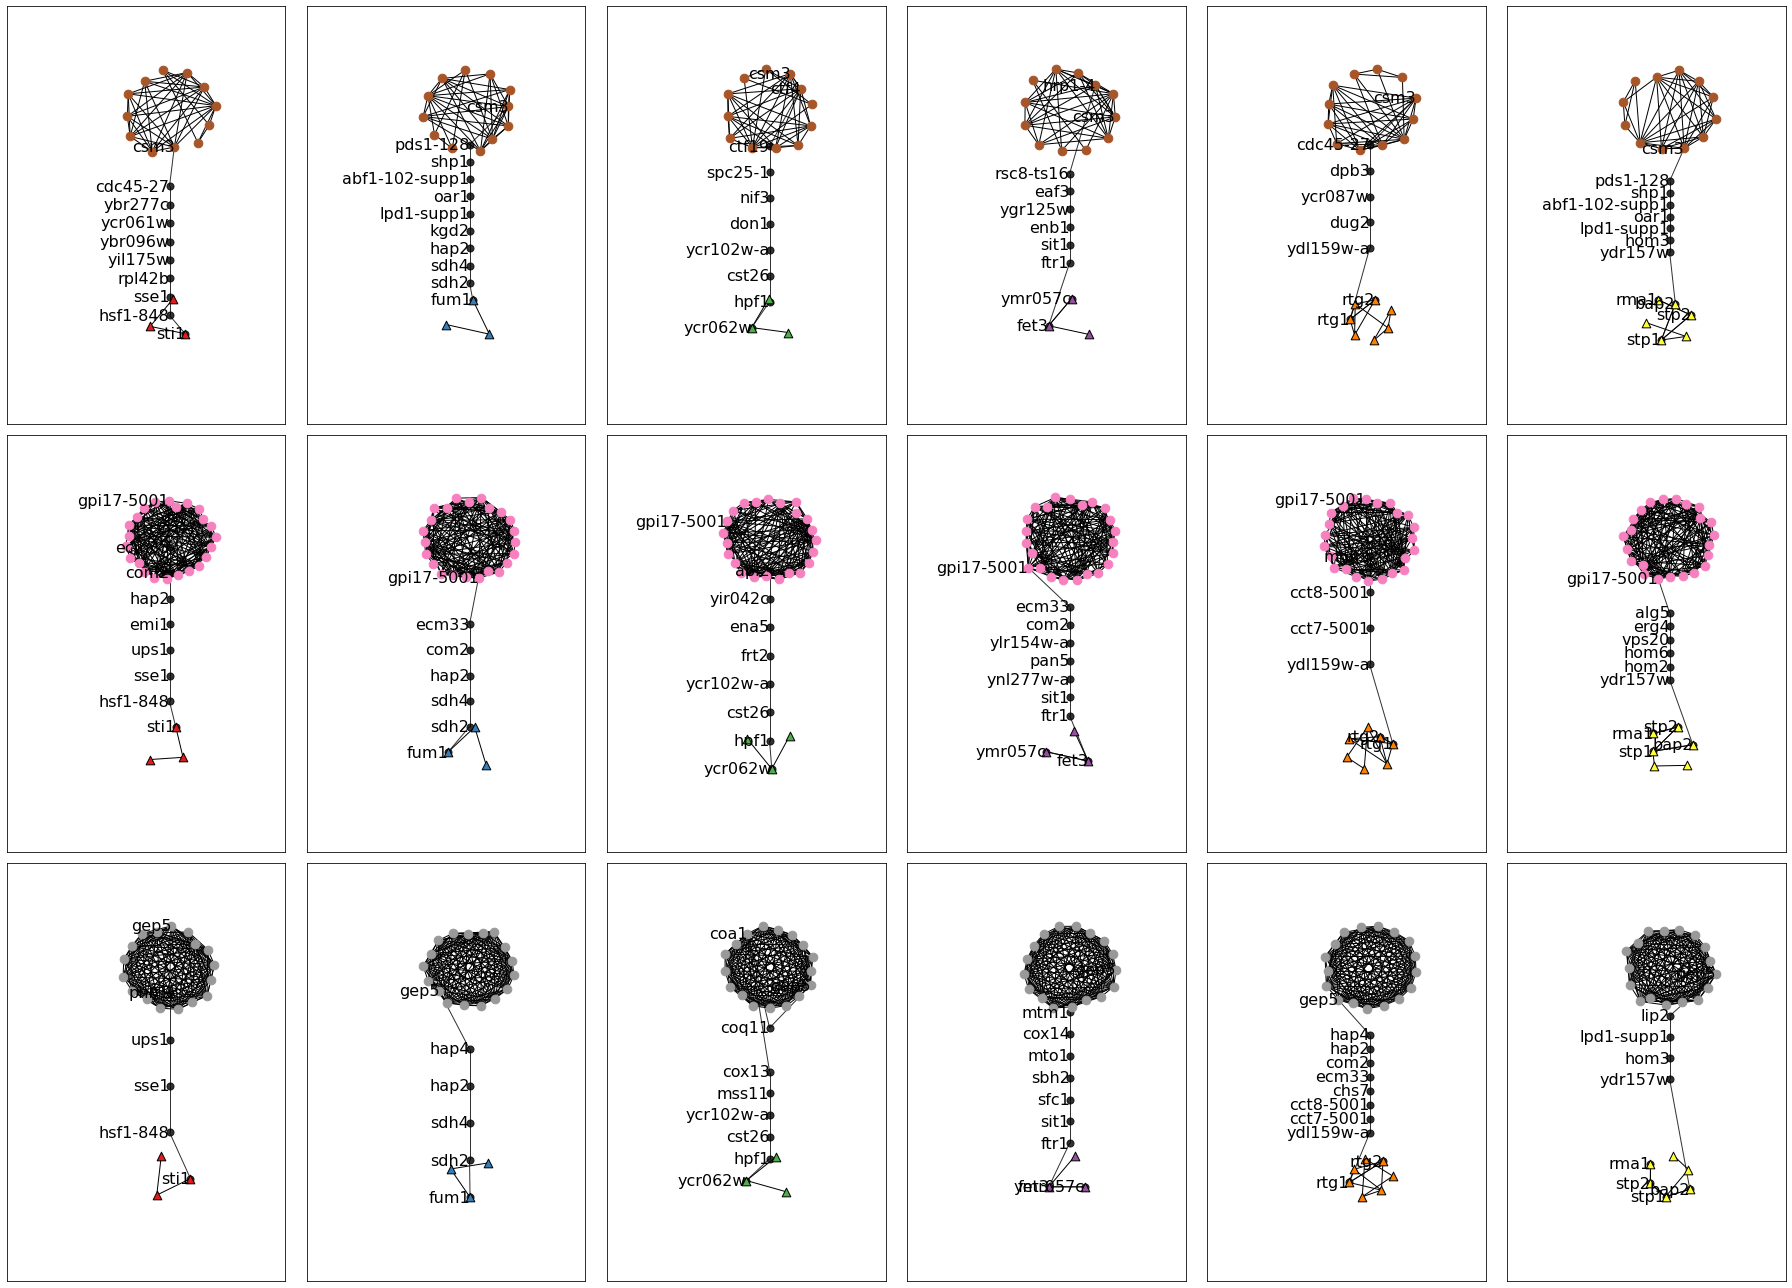

In [29]:
#sensor_pos['ymr057c']=np.array([5.2,-1])
fig, ax = plt.subplots(3,6,figsize=(25,18))

for i,eo in enumerate(effector_order):
    for j,so in enumerate(sensor_order):
        effector_go_group = eo
        sensor_go_group = so
        sensors_sub = nx.induced_subgraph(e_pcc.graph_gc, sensors_pcc.loc[sensors_pcc.go_group==sensor_go_group].orf_name)
        effectors_sub = nx.induced_subgraph(e_pcc.graph_gc, effector_pcc.loc[effector_pcc.go_group==effector_go_group].orf_name)
        sensor_pos, effector_pos, path_init_pos,sub,path_nodes, path_weight = get_path_positions(e_pcc, sensors_sub,effectors_sub)
        print(path_nodes)
        sens_plot = nx.draw_networkx_nodes(sensors_sub,
                                           pos=sensor_pos,
                                           ax=ax[i][j], 
                                           node_size=75,
                                           node_color=sensor_colors[j],
                                          node_shape='^',edgecolors='k')
        
        nx.draw_networkx_edges(sensors_sub,pos=sensor_pos,ax=ax[i][j])
        eff_plot = nx.draw_networkx_nodes(effectors_sub, 
                                          pos = effector_pos ,
                                          ax=ax[i][j],
                                          node_size=75,
                                          node_color=effector_colors[i])
        nx.draw_networkx_edges(effectors_sub, pos = effector_pos , ax=ax[i][j])
        path_plot=nx.draw_networkx_nodes(sub,
                                         pos=path_init_pos,
                                         alpha=0.8,
                                         node_size=50,
                                         ax=ax[i][j],
                            #  node_size = [prs_mat_df.loc[source,:].to_dict()[i]*10000 for i in sub.nodes],
                                         node_color = 'black')
#         nx.draw_networkx_labels(sub, 
#                                 pos=path_init_pos,
#                                 ax=ax[i][j],
#                                 font_size=14,
#                                horizontalalignment='right')
#         #if labels is None:
        labels = {n: n for n in sub.nodes()}

        text_items = {}  # there is no text collection so we'll fake one
        for n, label in labels.items():
            (x, y) = path_init_pos[n]
            if not isinstance(label, str):
                label = str(label)  # this makes "1" and 1 labeled the same
            t = ax[i][j].text(
                x,
                y,
                label,
                size=16,
                color='k',
                family="sans-serif",
                weight="normal",
                alpha=None,
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax[i][j].transData,
                bbox=None,
                clip_on=False,
            )

        nx.draw_networkx_edges(sub,pos=path_init_pos,alpha=0.8,ax=ax[i][j])
        path_plot.set_zorder(2)
        eff_plot.set_zorder(3)
        sens_plot.set_zorder(3)
        ax[i][j].set_xlim(-2,10)
        ax[i][j].set_ylim(-5,15)
        eff_sens_df.loc[eo,so]=str(path_nodes)
        filename = 'combined_041921'#"".join(x for x in f'{effector_go_group}_{sensor_go_group}' if x.isalnum())
        #plt.savefig(f'{folder}/{filename}.png',bbox_inches='tight',facecolor='white')
plt.tight_layout()

['csm3', 'cdc45-27', 'ybr277c', 'ycr061w', 'ybr096w', 'yil175w', 'rpl42b', 'sse1', 'hsf1-848', 'sti1']
['csm3', 'pds1-128', 'shp1', 'abf1-102-supp1', 'oar1', 'lpd1-supp1', 'kgd2', 'hap2', 'sdh4', 'sdh2', 'fum1']
['ctf4', 'ctf19', 'spc25-1', 'nif3', 'don1', 'ycr102w-a', 'cst26', 'hpf1', 'ycr062w']
['mad1', 'spc25-1', 'spc24-10', 'ask1-2', 'tvp18', 'fit3', 'sit1', 'ftr1', 'fet3', 'ymr057c']
['csm3', 'cdc45-27', 'dpb3', 'ycr087w', 'dug2', 'ydl159w-a', 'rtg1', 'rtg2']
['csm3', 'pds1-128', 'shp1', 'abf1-102-supp1', 'oar1', 'lpd1-supp1', 'hom3', 'ydr157w', 'bap2', 'stp1', 'stp2', 'rma1']
['gpi17-5001', 'ecm33', 'com2', 'hap2', 'emi1', 'ups1', 'sse1', 'hsf1-848', 'sti1']
['gpi17-5001', 'ecm33', 'com2', 'hap2', 'sdh4', 'sdh2', 'fum1']
['gpi17-5001', 'api2', 'yir042c', 'ena5', 'frt2', 'ycr102w-a', 'cst26', 'hpf1', 'ycr062w']
['gpi17-5001', 'ecm33', 'com2', 'ylr154w-a', 'pan5', 'ynl277w-a', 'sit1', 'ftr1', 'fet3', 'ymr057c']
['gpi17-5001', 'mnn2', 'cct8-5001', 'cct7-5001', 'ydl159w-a', 'rtg1', '

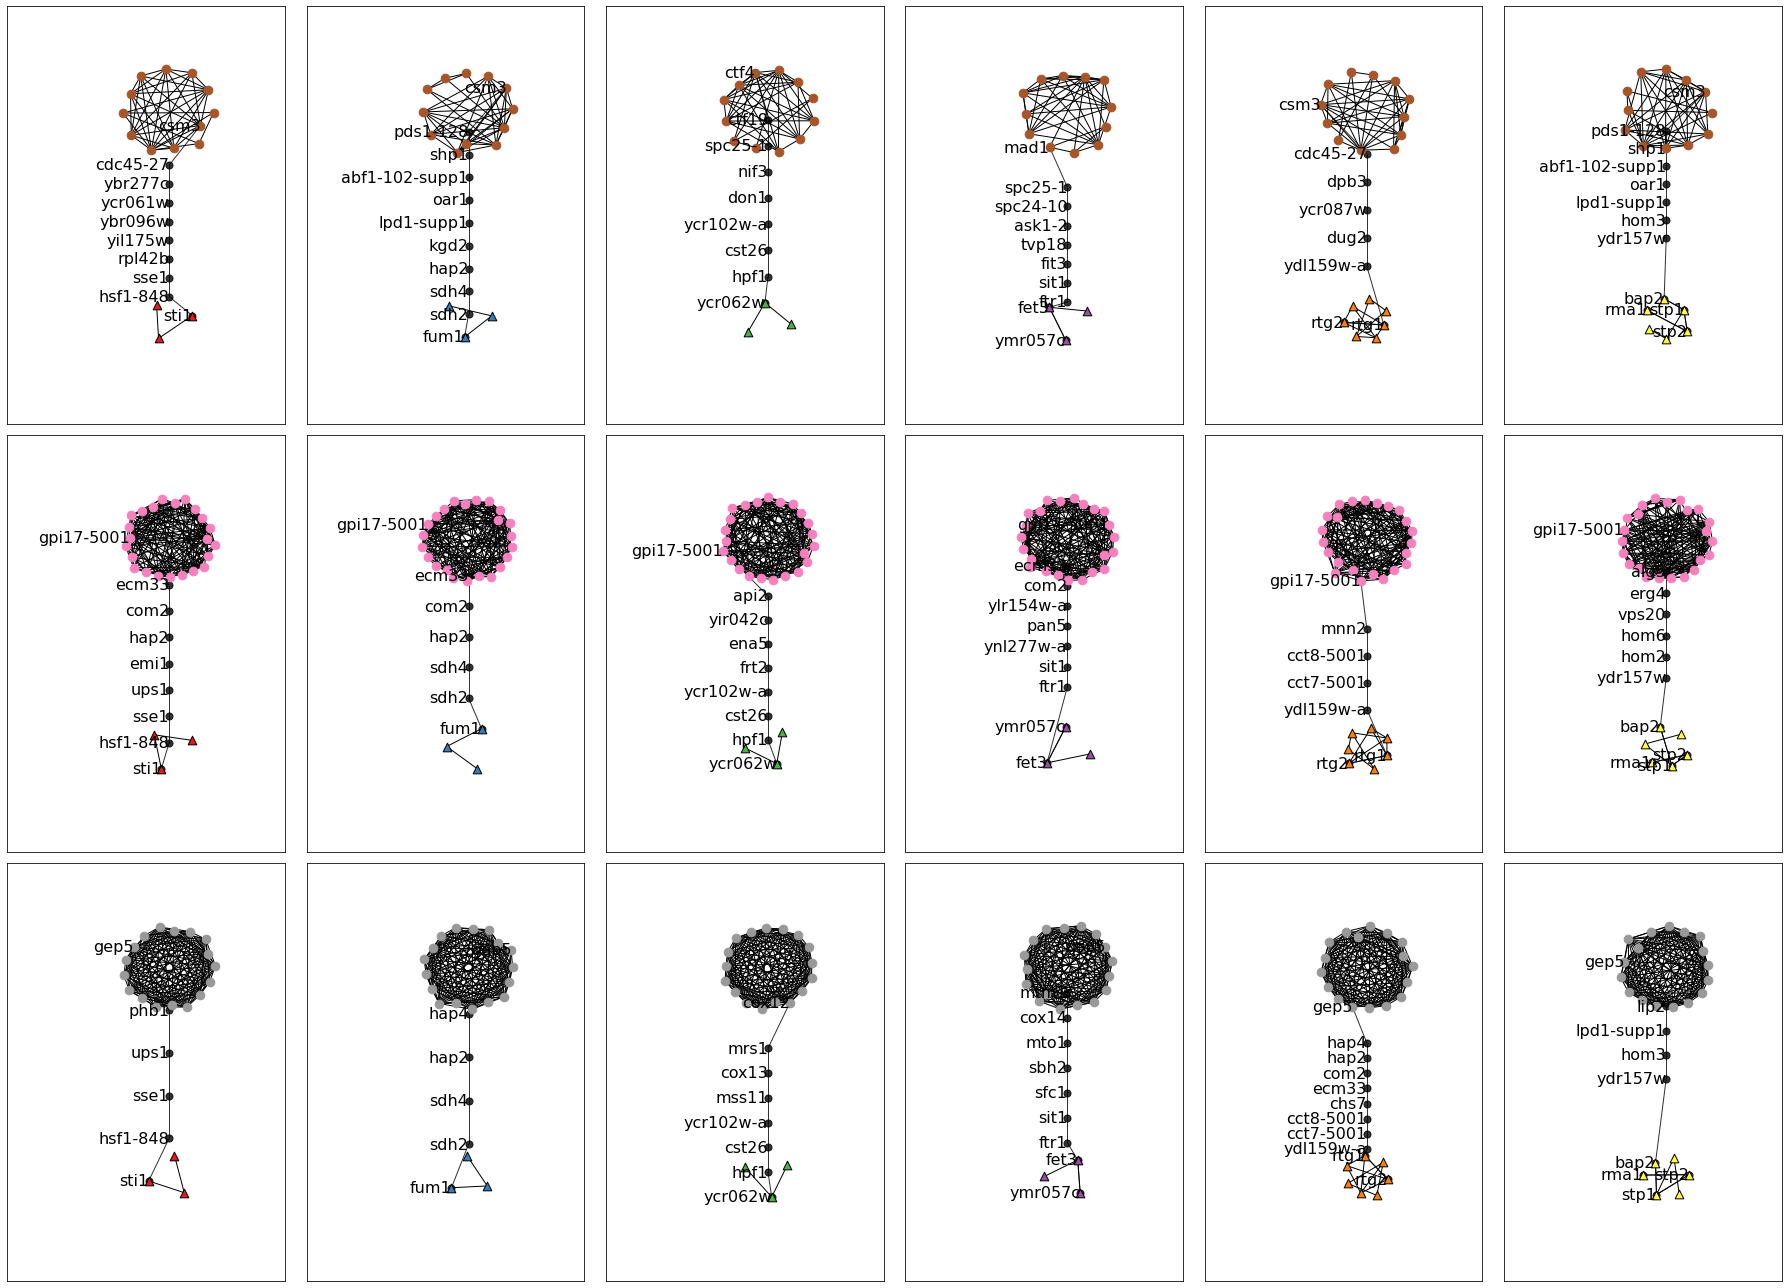

In [35]:
#sensor_pos['ymr057c']=np.array([5.2,-1])
fig, ax = plt.subplots(3,6,figsize=(25,18))

for i,eo in enumerate(effector_order):
    for j,so in enumerate(sensor_order):
        effector_go_group = eo
        sensor_go_group = so
        sensors_sub = nx.induced_subgraph(e_pcc.graph_gc, sensors_pcc.loc[sensors_pcc.go_group==sensor_go_group].orf_name)
        effectors_sub = nx.induced_subgraph(e_pcc.graph_gc, effector_pcc.loc[effector_pcc.go_group==effector_go_group].orf_name)
        sensor_pos, effector_pos, path_init_pos,sub,path_nodes, path_weight = get_path_positions(e_pcc, sensors_sub,effectors_sub)
        print(path_nodes)
        sens_plot = nx.draw_networkx_nodes(sensors_sub,
                                           pos=sensor_pos,
                                           ax=ax[i][j], 
                                           node_size=75,
                                           node_color=sensor_colors[j],
                                          node_shape='^',edgecolors='k')
        
        nx.draw_networkx_edges(sensors_sub,pos=sensor_pos,ax=ax[i][j])
        eff_plot = nx.draw_networkx_nodes(effectors_sub, 
                                          pos = effector_pos ,
                                          ax=ax[i][j],
                                          node_size=75,
                                          node_color=effector_colors[i])
        nx.draw_networkx_edges(effectors_sub, pos = effector_pos , ax=ax[i][j])
        path_plot=nx.draw_networkx_nodes(sub,
                                         pos=path_init_pos,
                                         alpha=0.8,
                                         node_size=50,
                                         ax=ax[i][j],
                            #  node_size = [prs_mat_df.loc[source,:].to_dict()[i]*10000 for i in sub.nodes],
                                         node_color = 'black')
#         nx.draw_networkx_labels(sub, 
#                                 pos=path_init_pos,
#                                 ax=ax[i][j],
#                                 font_size=14,
#                                horizontalalignment='right')
#         #if labels is None:
        labels = {n: n for n in sub.nodes()}

        text_items = {}  # there is no text collection so we'll fake one
        for n, label in labels.items():
            (x, y) = path_init_pos[n]
            if not isinstance(label, str):
                label = str(label)  # this makes "1" and 1 labeled the same
            t = ax[i][j].text(
                x,
                y,
                label,
                size=16,
                color='k',
                family="sans-serif",
                weight="normal",
                alpha=None,
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax[i][j].transData,
                bbox=None,
                clip_on=False,
            )

        nx.draw_networkx_edges(sub,pos=path_init_pos,alpha=0.8,ax=ax[i][j])
        path_plot.set_zorder(2)
        eff_plot.set_zorder(3)
        sens_plot.set_zorder(3)
        ax[i][j].set_xlim(-2,10)
        ax[i][j].set_ylim(-5,15)
        eff_sens_df.loc[eo,so]=str(path_nodes)
        filename = 'combined_041921'#"".join(x for x in f'{effector_go_group}_{sensor_go_group}' if x.isalnum())
        #plt.savefig(f'{folder}/{filename}.png',bbox_inches='tight',facecolor='white')
plt.tight_layout()

In [ ]:
#eff_sens_df.
eff_sens_df["orfs"]=eff_sens_df["orfs"].apply(eval)

In [ ]:
eff_sens_df_melted = eff_sens_df.orfs.apply(pd.Series).melt(value_name='orf_names',ignore_index=False).dropna()

In [ ]:
strain_ids = pd.read_csv('data/interim/strain_ids_with_experiment_count_all.csv')
sgd_features = pd.read_csv('data/raw/ontology/SGD_features.tab','\t',header=None)

In [ ]:
eff_sens_desc = (pd.merge(eff_sens_df_melted,strain_ids, right_on='Allele Gene name', left_on = 'orf_names', how='left').
 merge(sgd_features,left_on='Systematic gene name',right_on=3,how='left').
 set_index(eff_sens_df_melted.index)
)

In [ ]:
pd.merge(eff_sens_df_melted,strain_ids, right_on='Allele Gene name', left_on = 'orf_names', how='left'). set_index(eff_sens_df_melted.index).loc['mito','iron ion\ntransport']

In [ ]:
a=[]
for i,eo in enumerate(effector_order):
    for j,so in enumerate(sensor_order):
        a.append(eff_sens_desc.iloc[:,[1,2,9,22]].loc[eo,so])

In [ ]:
a[2]

In [ ]:
a[4]

In [ ]:
a[5]

In [ ]:
a[10]

In [ ]:
a[11]

In [ ]:
a[16]

In [ ]:
unch_containint_paths = [a[i] for  i in [2,4,10,16]]

In [ ]:
#sensor_pos['ymr057c']=np.array([5.2,-1])
fig, ax = plt.subplots(3,2,figsize=(25,18))
axs = np.ravel(ax)

for itr,i in enumerate(unch_containint_paths):
    eo, so = i.index[0]
    effector_go_group = eo
    sensor_go_group = so
    sensor_names = sensors_pcc.loc[sensors_pcc.go_group==sensor_go_group].orf_name.tolist()
    effector_names = effector_pcc.loc[effector_pcc.go_group==effector_go_group].orf_name.tolist()
    sensors_sub = nx.induced_subgraph(e_pcc.graph_gc,sensor_names )
    effectors_sub = nx.induced_subgraph(e_pcc.graph_gc, effector_names)
    sensor_pos, effector_pos, path_init_pos,sub,path_nodes = get_path_positions(sensors_sub,effectors_sub)
    eff_path_sens = np.unique(path_nodes+sensor_names+effector_names)
    eff_path_sens_network = nx.induced_subgraph(e_pcc.graph_gc, eff_path_sens)
    print(path_nodes)
    sens_plot = nx.draw_networkx_nodes(sensors_sub,
                                       pos=sensor_pos,
                                       ax=axs[itr], 
                                       node_size=75,
                                       #node_color=sensor_colors[j],
                                      node_shape='^',edgecolors='k')
    nx.draw_networkx_labels(sensors_sub,
                                           pos=sensor_pos,
                                           ax=axs[itr],
                           font_size=16)
        
    nx.draw_networkx_edges(sensors_sub,pos=sensor_pos,ax=axs[itr])
    eff_plot = nx.draw_networkx_nodes(effectors_sub, 
                                      pos = effector_pos ,
                                      ax=axs[itr],
                                      node_size=75)
                                      #node_color=effector_colors[i])
    nx.draw_networkx_edges(effectors_sub, pos = effector_pos , ax=axs[itr])
    path_plot=nx.draw_networkx_nodes(sub,
                                     pos=path_init_pos,
                                     alpha=0.8,
                                     node_size=50,
                                     ax=axs[itr],
                        #  node_size = [prs_mat_df.loc[source,:].to_dict()[i]*10000 for i in sub.nodes],
                                     node_color = 'black')
#         nx.draw_networkx_labels(sub, 
#                                 pos=path_init_pos,
#                                 ax=ax[i][j],
#                                 font_size=14,
#                                horizontalalignment='right')
#         #if labels is None:
    labels = {n: n for n in sub.nodes()}
    fname = "".join(x for x in f'{eo}_{so}' if x.isalnum())
    
    nx.to_pandas_edgelist(eff_path_sens_network).to_csv(f"data/interim/eff_sens_paths/{fname}.csv")
    text_items = {}  # there is no text collection so we'll fake one
    for n, label in labels.items():
        (x, y) = path_init_pos[n]
        if not isinstance(label, str):
            label = str(label)  # this makes "1" and 1 labeled the same
        t = axs[itr].text(
            x,
            y,
            label,
            size=16,
            color='k',
            family="sans-serif",
            weight="normal",
            alpha=None,
            horizontalalignment='right',
            verticalalignment='center',
            transform=axs[itr].transData,
            bbox=None,
            clip_on=False,
        )

    nx.draw_networkx_edges(sub,pos=path_init_pos,alpha=0.8,ax=axs[itr])
    path_plot.set_zorder(2)
    eff_plot.set_zorder(3)
    sens_plot.set_zorder(3)
    axs[itr].set_xlim(-2,10)
    axs[itr].set_ylim(-5,15)
    eff_sens_df.loc[eo,so]=str(path_nodes)
    filename = 'combined_041921'#"".join(x for x in f'{effector_go_group}_{sensor_go_group}' if x.isalnum())
    #plt.savefig(f'{folder}/{filename}.png',bbox_inches='tight',facecolor='white')
plt.tight_layout()

In [ ]:
unch_containint_paths[3].iloc[2,3]